In [54]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn import metrics

In [22]:
df0 = pd.read_csv("/Users/ketansand/Downloads/Flight_Data/clean_data.csv", parse_dates=[1])
df0 = df0.loc[:, ~df0.columns.str.contains('^Unnamed')]

In [23]:
df0 = df0[df0['DEP_DELAY']>15]

In [24]:
df0['DELAY_range'] = df0['DEP_DELAY'].apply(lambda x: 1 if x <= 30 else x)
df0['DELAY_range'] = df0['DELAY_range'].apply(lambda x: 2 if (30 < x < 60) else x)
df0['DELAY_range'] = df0['DELAY_range'].apply(lambda x: 3 if x >= 60 else x)

# One-hot encode categorical variables
df0 = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot

# Convert cyclical vars (frac_day & frac_year) to sin and cos columns
df0 = df0.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
df0 = df0.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
df0 = df0.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
df0 = df0.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
df0 = df0.drop(columns=['FRAC_DAY','FRAC_YEAR'])

# Additional cleaning
df0 = df0.drop(columns=['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY'])
df0 = df0.loc[:, ~df0.columns.str.contains('^Unnamed')]

In [25]:
gc.collect()

90

In [26]:
test = df0['FL_DATE'].dt.year.isin([2023]) & df0['FL_DATE'].dt.month.isin([7,8])
df_test = df0[test]
df_train = df0[~test]

y_test = df_test['DELAY_range']
X_test = df_test.drop(columns=['DELAY_range','FL_DATE'])

y_train = df_train['DELAY_range']
X_train = df_train.drop(columns=['DELAY_range']) 

In [27]:
X_test[['AIR_TIME']].head(3)

,AIR_TIME
13534026,98.0
13534029,105.0
13534038,109.0


In [28]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[['AIR_TIME']])

X_train[['AIR_TIME']] = scaler.transform(X_train[['AIR_TIME']])
X_test[['AIR_TIME']] = scaler.transform(X_test[['AIR_TIME']])

In [29]:
X_test[['AIR_TIME']].head(3)

,AIR_TIME
13534026,0.135802
13534029,0.148148
13534038,0.155203


In [30]:
print(scaler.data_min_)
print(scaler.data_max_)

[21.]
[588.]


In [31]:
year_column = X_train['FL_DATE'].dt.year
i_covid = np.logical_or(year_column == 2020, year_column == 2021).values

In [32]:
fy=2022
i_t = (year_column >= fy).values
X_t = X_train.iloc[i_t].drop(columns=['FL_DATE'])
y_t = y_train.iloc[i_t]

In [33]:
X_tt, X_val, y_tt, y_val = train_test_split(X_t, y_t,
                                            shuffle=True,
                                            random_state=514,
                                            test_size=.2)

In [34]:
del df0,df_test,df_train

In [35]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model to the training data
model.fit(X_tt, y_tt)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [39]:
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

joblib.dump(model,'log_reg_delay_range_22_23.joblib', compress=5)

Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

         1.0       0.40      0.50      0.44     28615
         2.0       0.37      0.00      0.01     24765
         3.0       0.41      0.65      0.51     29892

    accuracy                           0.41     83272
   macro avg       0.39      0.38      0.32     83272
weighted avg       0.40      0.41      0.34     83272



['log_reg_delay_range_22_23.joblib']

In [40]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_tt, y_tt)

RandomForestClassifier(random_state=42)

In [52]:
y_pred = rf_classifier.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

joblib.dump(rf_classifier,'rf_delay_range_22_23.joblib', compress=5)

Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

         1.0       0.65      0.71      0.68     28615
         2.0       0.60      0.51      0.55     24765
         3.0       0.67      0.70      0.68     29892

    accuracy                           0.64     83272
   macro avg       0.64      0.64      0.64     83272
weighted avg       0.64      0.64      0.64     83272



['rf_delay_range_22_23.joblib']

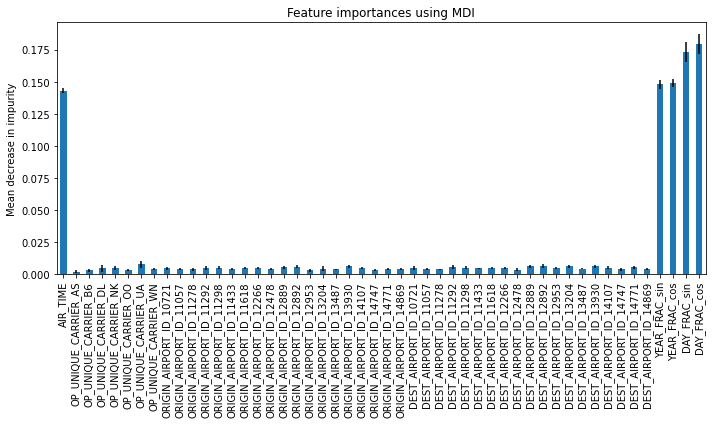

In [43]:
# feature importance based on impurity
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

feature_names = X_tt.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('RF_delayrange_feature_importance_imp.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_tt = le.fit_transform(y_tt)

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_tt)), random_state=42, 
                                   n_estimators = 100, max_depth=10)

# Fit the model to the training data
xgb_classifier.fit(X_tt, y_tt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [51]:
y_pred = xgb_classifier.predict(X_val)
y_pred = le.inverse_transform(y_pred)
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


joblib.dump(xgb_classifier,'xg_delay_range_22_23.joblib', compress=5)

Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

         1.0       0.57      0.65      0.61     28615
         2.0       0.53      0.37      0.43     24765
         3.0       0.60      0.67      0.63     29892

    accuracy                           0.57     83272
   macro avg       0.57      0.56      0.56     83272
weighted avg       0.57      0.57      0.56     83272



['xg_delay_range_22_23.joblib']